In [71]:
pip install haversine

Note: you may need to restart the kernel to use updated packages.


In [72]:
!pip install folium

In [214]:
#Importando as bibliotecas

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

from haversine import haversine

import folium
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_score
import warnings

## Banco de dados

In [188]:
#Importando o banco de dados
data1 = pd.read_csv('Questão 2 - Base 1.txt', delim_whitespace = True)
data2 = pd.read_csv('Questão 2 - Base 2.txt', delim_whitespace = True)
data3 = pd.read_csv('Questão 2 - Base 3.txt', delim_whitespace = True)
data4 = pd.read_csv('Questão 2 - Base 4.txt', delim_whitespace = True)
data5 = pd.read_csv('Questão 2 - Base 5.txt', delim_whitespace = True)

In [180]:
df = data1.merge(data2)

In [183]:
df = df.merge(data3)

In [193]:
df = df[['NU_DIAS_ATRASO', 'VALOR_CRELIQ', 'DIVIDA_ATUAL', 'RESPOSTA', 'LIMITE', 'QTD_PARCELAMENTO_12M']]

In [196]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72539 entries, 0 to 72538
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   NU_DIAS_ATRASO        72539 non-null  int64  
 1   VALOR_CRELIQ          72539 non-null  float64
 2   DIVIDA_ATUAL          72539 non-null  float64
 3   RESPOSTA              72539 non-null  int64  
 4   LIMITE                72539 non-null  float64
 5   QTD_PARCELAMENTO_12M  72539 non-null  int64  
dtypes: float64(3), int64(3)
memory usage: 3.9 MB


In [194]:
dataset = df.values

## Pré - Processamento

Objetivando o aumento da adesão dos acordos, decidiu-se fazer um agrupamente de clientes, esse agrupamento, ou Clusterização, é feito por meio do algoritmo Kmeans que é conhecida como aprendizagem Não-Supervisionada.
O modelo K-Means é um método de segregar em torno de centros (centroides) diversos dados, criando o que chamamos de clustering, que gera o efeito de particionar 'n' observações dentre 'k' grupos onde cada observação pertence ao grupo mais próximo da média.

In [200]:
df, amostra2 = train_test_split(dataset, train_size=.2)

In [201]:
df.shape

(14507, 6)

## Máquina Preditiva

In [202]:
#Aplica a redução de dimensionalidade no array das variáveis
pca = PCA(n_components=2).fit_transform(df)

In [208]:
#Determinando um range do Hyperparâmetro 'k' do KMeans
k_range = range(1,6)
k_range

range(1, 6)

In [209]:
#Aplicando o modelo K-Means para cada valor de k
k_means_var = [KMeans(n_clusters=k).fit(pca) for k in k_range]

Text(0.5, 1.0, 'Variância explicada para cada valor de K')

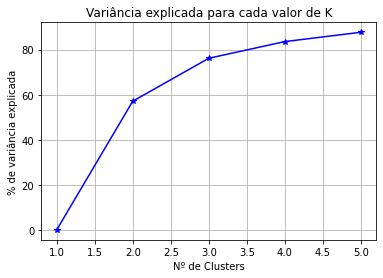

In [210]:
#Curva de Elbow
##Ajustando o centroide do cluster para cada modelo
centroids = [X.cluster_centers_ for X in k_means_var]

##Calculando a distância euclidiana de cada ponto de dado para o centróide
k_euclid = [cdist(pca,cent, 'euclidean') for cent in centroids]
dist = [np.min(ke, axis = 1) for ke in k_euclid]

##Soma dos quadrados da distância dentro do Cluster
soma_quadrados_intra_cluster = [sum(d**2) for d in dist]

##Soma total dos quadrados
soma_total = sum(pdist(pca)**2)/pca.shape[0]

##Soma dos quadrados entre os clusters
soma_quadrados_inter_cluster = soma_total - soma_quadrados_intra_cluster

##Curva de Elbow
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, soma_quadrados_inter_cluster/soma_total *100, 'b*-')
plt.grid(True)
plt.xlabel('Nº de Clusters')
plt.ylabel('% de variância explicada')
plt.title('Variância explicada para cada valor de K')

Observa- se na figura acima que para 3 clusters conseguimos explicar mais de 70% da variaância, para 4 clusters aproximadamente 80% e 5 clusters um pouco mais de 80%. As porcentagens são bem próximas, mas como para k=4 e k=5 as porcentagens são muito parecidas, partiremos do pressuposto que o modelo com 4 clusters é o melhor.

In [212]:
#Criar Modelo com k = 4
modelo_v1 = KMeans(n_clusters= 4)
modelo_v1.fit(pca)

KMeans(n_clusters=4)

In [ ]:
#Obtem os valores (Ocorre um erro inesperado de memory ao tentar plotar)
#x_min, x_max = pca[:,0].min() - 5, pca[:,0].max() - 1
#y_min, y_max = pca[:,1].min() + 1, pca[:,1].max() + 5
#xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
#Z = modelo_v1.predict(np.c_[xx.ravel(), yy.ravel()])
#Z = Z.reshape(xx.shape)

## Avaliação da Máquina Preditiva

In [217]:
#Métrica de Avaliação para clusterização
#Avaliando a máquina preditiva com k=4
labels = modelo_v1.labels_

silhouette_score(pca,labels, metric='euclidean')

0.5295795972308456

In [223]:
#Criar Modelo com k = 3
modelo_v2 = KMeans(n_clusters= 3)
modelo_v2.fit(pca)

KMeans(n_clusters=3)

In [224]:
#Métrica de Avaliação para clusterização
#Avaliando a máquina preditiva com k=3
labels = modelo_v2.labels_

silhouette_score(pca,labels, metric='euclidean')

0.5733368465386303

O coeficiente de Silhouette quando próximo de +1, indica que os pontos estão muito longe dos pontos do outro cluster, e quando próximo de 0, indica que os pontos então muito perto ou até interseccionando um outro cluster. Para k=4 temos 0,53 e para k=3 temos 0,57. Como a curva de Elbow nos mostra que a explicação da variância deles são parecidas, optaremos por escolher o modelo com k=3.

## Usando a marcação dos clusters na Máquina Preditiva Final

In [225]:
#Lista com o nome das colunas
names = ['NU_DIAS_ATRASO','VALOR_CRELIQ','DIVIDA_ATUAL','RESPOSTA','LIMITE', 'QTD_PARCELAMENTO_12M']

In [226]:
cluster_map = pd.DataFrame(df, columns=names)
cluster_map['cluster'] = modelo_v2.labels_

In [227]:
cluster_map

,NU_DIAS_ATRASO,VALOR_CRELIQ,DIVIDA_ATUAL,RESPOSTA,LIMITE,QTD_PARCELAMENTO_12M,cluster
0,436.0,3974.91,8527.74,0.0,3308.0,0.0,0
1,419.0,1085.47,2301.79,0.0,688.0,0.0,2
2,215.0,1193.34,1699.36,0.0,560.0,0.0,2
3,527.0,861.60,2210.11,0.0,281.0,0.0,2
4,257.0,277.61,425.61,0.0,225.0,2.0,2
...,...,...,...,...,...,...,...
14502,257.0,1089.52,1670.36,0.0,919.0,0.0,2
14503,311.0,294.76,501.88,0.0,225.0,0.0,2
14504,384.0,3288.10,6514.29,0.0,2188.0,0.0,1
14505,195.0,1032.12,1416.53,0.0,1461.0,1.0,2


In [228]:
#Média do número de atrasos por cluster
cluster_map.groupby('cluster')['NU_DIAS_ATRASO'].mean()

cluster
0    390.699104
1    368.959820
2    301.207637
Name: NU_DIAS_ATRASO, dtype: float64

In [229]:
#Limite médio por cluster
cluster_map.groupby('cluster')['LIMITE'].mean()

cluster
0    3654.989757
1    1727.645567
2     740.138712
Name: LIMITE, dtype: float64

In [233]:
pd.crosstab(cluster_map['cluster'], cluster_map['RESPOSTA'], margins=True)

RESPOSTA,0.0,1.0,All
cluster,,,
0,770,11,781
1,4369,86,4455
2,8956,315,9271
All,14095,412,14507


A partir do modelo vai ser possível fazer estudos para efetivar esse aumento na adesão dos acordos. Por exemplo, os clientes do cluster 2, que são a maioria, normalmente não aderem aos acordos. A partir disso buscar os motivos que o levam a não aderir.
- Esse cliente já está com muitos dias de atraso e prefere deixar como está?
- O valor da dívida com juros está muito alto?

In [230]:
#Salva o banco criado em xlsx
file_name = 'ModeloK-Means.xlsx'
  
# saving the excel
cluster_map.to_excel(file_name)